In [2]:
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/images'

import os
print(os.listdir(folder_path))


Mounted at /content/drive
['008_HC.png', '000_HC.png', '006_HC.png', '005_HC.png', '004_HC.png', '003_HC.png', '009_HC.png', '010_2HC.png', '002_HC.png', '007_HC.png', '010_HC.png', '011_HC.png', '001_HC.png', '014_2HC.png', '016_HC.png', '019_HC.png', '017_HC.png', '015_HC.png', '017_2HC.png', '019_2HC.png', '013_HC.png', '018_HC.png', '012_HC.png', '014_3HC.png', '014_HC.png', '026_2HC.png', '027_HC.png', '026_HC.png', '028_HC.png', '024_HC.png', '023_2HC.png', '023_HC.png', '021_HC.png', '022_HC.png', '020_HC.png', '022_2HC.png', '025_HC.png', '036_HC.png', '032_HC.png', '031_HC.png', '033_HC.png', '035_HC.png', '039_HC.png', '038_HC.png', '032_2HC.png', '033_2HC.png', '029_HC.png', '037_HC.png', '030_HC.png', '034_HC.png', '044_HC.png', '042_HC.png', '040_HC.png', '043_HC.png', '049_HC.png', '045_HC.png', '041_HC.png', '047_HC.png', '046_HC.png', '048_HC.png', '052_HC.png', '054_HC.png', '053_HC.png', '055_HC.png', '051_HC.png', '057_HC.png', '050_2HC.png', '059_HC.png', '056_HC.pn

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

In [4]:

image_path = '/content/drive/My Drive/images/000_HC.png'

image = Image.open(image_path).convert('L')


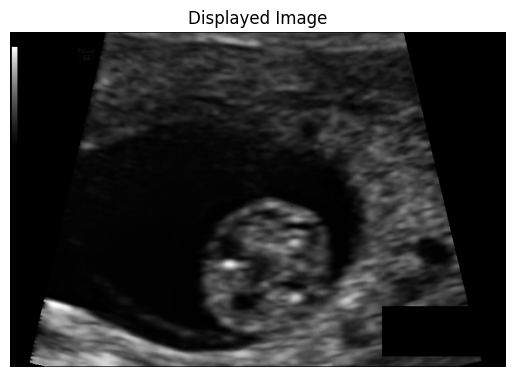

In [5]:

plt.imshow(image, cmap='gray')
plt.title('Displayed Image')
plt.axis('off')
plt.show()


Data loader

In [6]:
import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class LandmarkDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_size=(256, 256)):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('L')
        image = image.resize(self.target_size)

        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float').reshape(-1, 2)

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'landmarks': landmarks}

csv_file = '/content/drive/MyDrive/role_challenge_dataset_ground_truth.csv'
root_dir = '/content/drive/MyDrive/images'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

landmark_dataset = LandmarkDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)


 Model Design

In [28]:
import torch
import torch.nn as nn

class LandmarkDetectionModel(nn.Module):
    def __init__(self):
        super(LandmarkDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)


        self.fc1_input_size = 64 * 64 * 64
        self.fc1 = nn.Linear(self.fc1_input_size, 100)
        self.fc2 = nn.Linear(100, 8)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        print("After conv1:", x.size())
        x = self.pool(x)
        print("After max pooling 1:", x.size())
        x = torch.relu(self.conv2(x))
        print("After conv2:", x.size())
        x = self.pool(x)
        print("After max pooling 2:", x.size())
        x = x.view(-1, self.fc1_input_size)
        print("After flattening:", x.size())
        x = torch.relu(self.fc1(x))
        print("After fc1:", x.size())
        x = self.fc2(x)
        print("Final output size:", x.size())
        return x

model = LandmarkDetectionModel()

Loss

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Splitting the data



In [30]:
from torch.utils.data import DataLoader, random_split
train_size = int(0.6 * len(landmark_dataset))
val_size = int(0.2 * len(landmark_dataset))
test_size = len(landmark_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(landmark_dataset, [train_size, val_size, test_size])


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training the Model over Training Data

In [31]:
# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        images, landmarks = batch['image'], batch['landmarks']

        optimizer.zero_grad()
        outputs = model(images)
        landmarks = landmarks.view(-1, 8)
        loss = criterion(outputs, landmarks.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

After conv1: torch.Size([128, 32, 256, 256])
After max pooling 1: torch.Size([128, 32, 128, 128])
After conv2: torch.Size([128, 64, 128, 128])
After max pooling 2: torch.Size([128, 64, 64, 64])
After flattening: torch.Size([128, 262144])
After fc1: torch.Size([128, 100])
Final output size: torch.Size([128, 8])
Epoch [1/10], Batch [1/3], Loss: 140774.0938
After conv1: torch.Size([128, 32, 256, 256])
After max pooling 1: torch.Size([128, 32, 128, 128])
After conv2: torch.Size([128, 64, 128, 128])
After max pooling 2: torch.Size([128, 64, 64, 64])
After flattening: torch.Size([128, 262144])
After fc1: torch.Size([128, 100])
Final output size: torch.Size([128, 8])
Epoch [1/10], Batch [2/3], Loss: 127670.3125
After conv1: torch.Size([117, 32, 256, 256])
After max pooling 1: torch.Size([117, 32, 128, 128])
After conv2: torch.Size([117, 64, 128, 128])
After max pooling 2: torch.Size([117, 64, 64, 64])
After flattening: torch.Size([117, 262144])
After fc1: torch.Size([117, 100])
Final output s

In [35]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Hypothesis_1.pth')

Testing Data

In [32]:
# Testing the model
model.eval()
test_loss = 0.0

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images, landmarks = batch['image'], batch['landmarks']
        outputs = model(images)
        landmarks = landmarks.view(-1, 8)
        loss = criterion(outputs, landmarks.float())
        test_loss += loss.item() * images.size(0)

        print(f'Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}')

test_loss /= len(test_dataset)
print(f'Test Loss: {test_loss:.4f}')

After conv1: torch.Size([125, 32, 256, 256])
After max pooling 1: torch.Size([125, 32, 128, 128])
After conv2: torch.Size([125, 64, 128, 128])
After max pooling 2: torch.Size([125, 64, 64, 64])
After flattening: torch.Size([125, 262144])
After fc1: torch.Size([125, 100])
Final output size: torch.Size([125, 8])
Test Batch [1/1], Loss: 9748.1006
Test Loss: 9748.1006


Validating the data

In [33]:
# Evaluating the model on validation set
val_loss = 0.0

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        images, landmarks = batch['image'], batch['landmarks']
        outputs = model(images)
        landmarks = landmarks.view(-1, 8)
        loss = criterion(outputs, landmarks)
        val_loss += loss.item() * images.size(0)

        print(f'Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}')

val_loss /= len(val_dataset)
print(f'Validation Loss: {val_loss:.4f}')

After conv1: torch.Size([124, 32, 256, 256])
After max pooling 1: torch.Size([124, 32, 128, 128])
After conv2: torch.Size([124, 64, 128, 128])
After max pooling 2: torch.Size([124, 64, 64, 64])
After flattening: torch.Size([124, 262144])
After fc1: torch.Size([124, 100])
Final output size: torch.Size([124, 8])
Validation Batch [1/1], Loss: 10270.3426
Validation Loss: 10270.3426


Inference of single image

In [34]:

single_image_path = '/content/drive/MyDrive/images/000_HC.png'
single_image = Image.open(single_image_path).convert('L')
single_image = single_image.resize((256, 256))
single_image = transform(single_image).unsqueeze(0)


with torch.no_grad():
    model.eval()
    predicted_landmarks = model(single_image)


print("Predicted Landmarks:")
print(predicted_landmarks)


After conv1: torch.Size([1, 32, 256, 256])
After max pooling 1: torch.Size([1, 32, 128, 128])
After conv2: torch.Size([1, 64, 128, 128])
After max pooling 2: torch.Size([1, 64, 64, 64])
After flattening: torch.Size([1, 262144])
After fc1: torch.Size([1, 100])
Final output size: torch.Size([1, 8])
Predicted Landmarks:
tensor([[345.5542, 120.5092, 343.0373, 404.2585, 200.9172, 276.5003, 566.8120,
         266.9365]])
